## Introduction

I found Kaggle's Course [Clustering With K-Means](https://www.kaggle.com/code/ryanholbrook/clustering-with-k-means) is very helpful for beginners to learn how K-Means cluster labels. However, it uses `KMeans(n_clusters=6)` without any explaination.

Is 6 the best number of clusters? I'd like to find out the answer.

## Data

The data used in this example is [housing.csv](https://www.kaggle.com/code/ryanholbrook/clustering-with-k-means/data?select=housing.csv), which is based on [California Housing Prices](https://www.kaggle.com/datasets/camnugent/california-housing-prices), with some small transformations, such as excluding some unnecessary columns and calculating the average # of rooms/bedrooms. The columns of California Housing Prices are very self explanitory, so we can use it as metadata.

The columns of [housing.csv](https://www.kaggle.com/code/ryanholbrook/clustering-with-k-means/data?select=housing.csv) are as follows:

- `MedInc`: median income, in the area with same longtitude & latitude.
- `HouseAge`: median house age, in the area with same longtitude & latitude.
- `AveRooms`: average # of rooms, in the area with same longtitude & latitude.
- `AveBedrms`: average # of bedrooms, in the area with same longtitude & latitude.
- `Population`: total population, in the area with same longtitude & latitude.
- `AveOccup`: average # of people per house, in the area with same longtitude & latitude. 
- `Latitude`: latitude of this area
- `Longitude`: longitude of this area
- `MedHouseVal`: median house value, in the area with same longtitude & latitude.

## Goals

**Original Goal**: `Latitude` and `Longitude` make natural candidates for K-Means clustering. In this example we'll cluster these with `MedInc` (median income) to create a new feature `Cluster` as indicator of economic segments in different regions of California.

**Goal of this Post**: Find out the optimal number of clusters for K-Means, with 2 methods: **Elbow Method** and **Silhouette Analysis**.

## Import required libraries

In [2]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.cm as cm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

df = pd.read_csv("data/housing.csv")
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


Get the data for K-Means.

In [3]:
X = df.loc[:, ["MedInc", "Latitude", "Longitude"]]
X.head()

,MedInc,Latitude,Longitude
0,8.3252,37.88,-122.23
1,8.3014,37.86,-122.22
2,7.2574,37.85,-122.24
3,5.6431,37.85,-122.25
4,3.8462,37.85,-122.25


## Find the optimal number of clusters 

### Method 1 - Elbow Method

[Elbow Method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) can help data scientists select the optimal number of clusters by fitting the model with a range of values for K. If the line chart resembles an arm, then the “elbow” (the point of inflection on the curve) is a good indication that the underlying model fits best at that point.

I'm going to create a custom function, which will use `inertia_`, the sum of squared (Eculidean) distances of samples to their closest cluster center as the y axis.

#### Custom Function

inertia_ when n_clusters=2: 101042.1168227169
inertia_ when n_clusters=3: 73393.53387585166
inertia_ when n_clusters=4: 56518.08499413778
inertia_ when n_clusters=5: 47169.01817544224
inertia_ when n_clusters=6: 39488.537833215145
inertia_ when n_clusters=7: 34708.88016741261
inertia_ when n_clusters=8: 30739.4113394307
inertia_ when n_clusters=9: 27670.50911724596


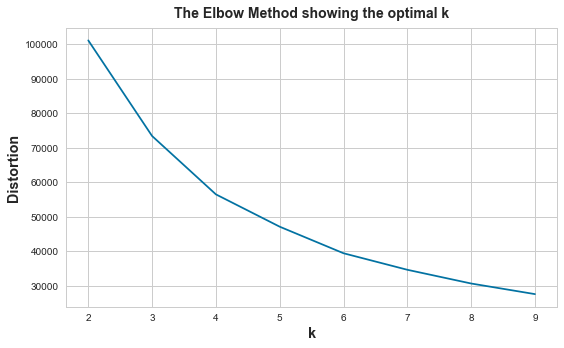

In [84]:
def plot_kmeans_elbow(X, range_n_clusters=[2]):
    # Running K Means with a range of k
    inertias = []
    mapping = {}
    for k in range_n_clusters:
        kmeanModel = KMeans(n_clusters=k, random_state=42)
        kmeanModel.fit(X)
        # inertia_: sum of squared distances of samples to their closest cluster center, 
        # weighted by the sample weights if provided.
        inertias.append(kmeanModel.inertia_)
        mapping[k] = kmeanModel.inertia_

    # Print inertia_
    for key, val in mapping.items():
        print(f'inertia_ when n_clusters={key}: {val}')
        
    # Plotting the distortions of K-Means
    plt.figure(figsize=(8,5))
    plt.plot(range_n_clusters, inertias, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()
    
# from 2 to 10, which is the optimal K?
plot_kmeans_elbow(X, range_n_clusters=[x for x in range(2, 10)])

According to the sum of squared distances and image above, seems the "elbow" point is 4, but not obvious.

Actually, we don't need to create custom functions to apply the Elbow Method. [Yellowbrick](https://www.scikit-yb.org/en/latest/quickstart.html), which extends the Scikit-Learn API to make model selection and hyperparameter tuning easier, provides a visualizer model [KElbowVisualizer](https://www.scikit-yb.org/en/latest/api/cluster/elbow.html) that do so. Let's check how it works.

#### KElbowVisualizer

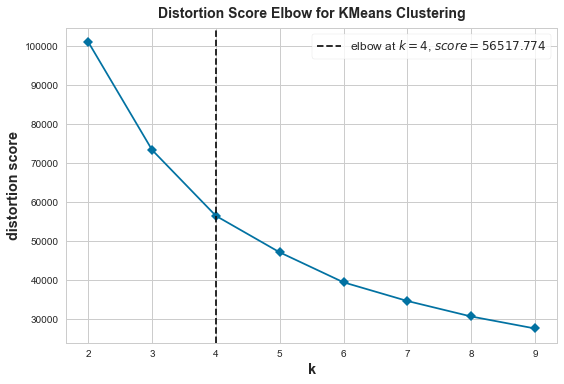

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [42]:
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,10), timings=False)

# Fit the data to the visualizer
visualizer.fit(X)
# Finalize and render the figure
visualizer.show() 

The Elbow Method shows 4 is the optimal number of clusters.

### Method 2: Silhouette Analysis

[Silhouette](https://en.wikipedia.org/wiki/Silhouette_(clustering)) coefficient is a measure of how similar a sample is to its own cluster (cohesion) compared to other clusters (separation), its range is [-1, 1]. When it's closer to 1, the sample is perfectly clustered. When it's smaller than 0, that sample is probably in the wrong cluster.

According to [Scikit-learn: Selecting the number of clusters with silhouette analysis on KMeans clustering](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html), there are 3 signs of bad clusters:

1. **The presence of clusters with below average silhouette scores**
2. **Wide fluctuations in the size of silhouette plots**
3. **Non-uniform thickness of silhouette plots**

Let's create a custom function to visualize the silhouette plots.

#### Custom Function

The function below is from [sklearn](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) with some modifications.

The average silhouette_score of n_clusters=2: 0.567
The average silhouette_score of n_clusters=3: 0.503
The average silhouette_score of n_clusters=4: 0.425
The average silhouette_score of n_clusters=5: 0.375
The average silhouette_score of n_clusters=6: 0.399
The average silhouette_score of n_clusters=7: 0.363
The average silhouette_score of n_clusters=8: 0.345
The average silhouette_score of n_clusters=9: 0.35


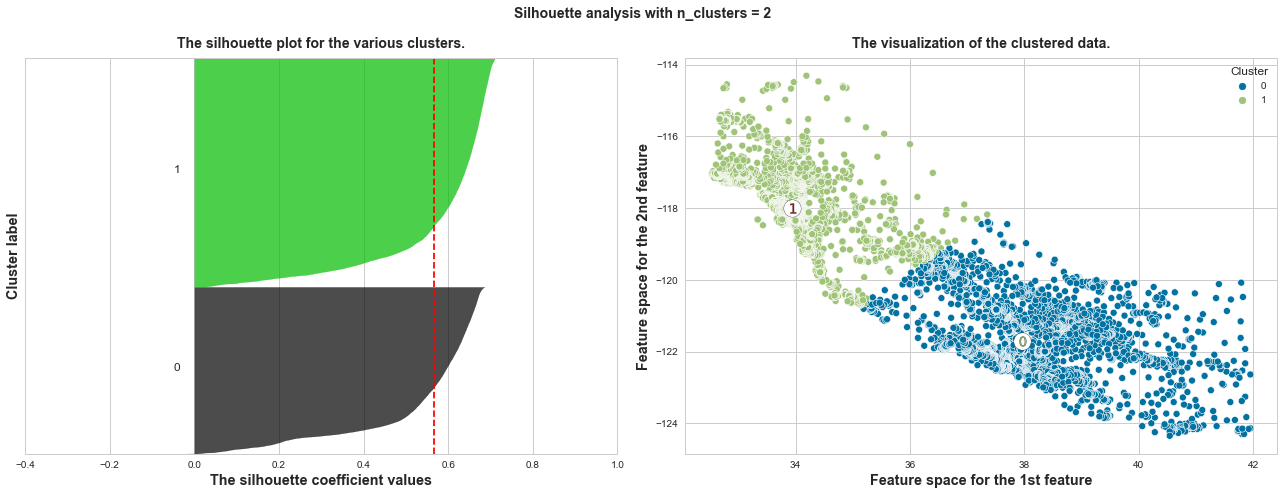

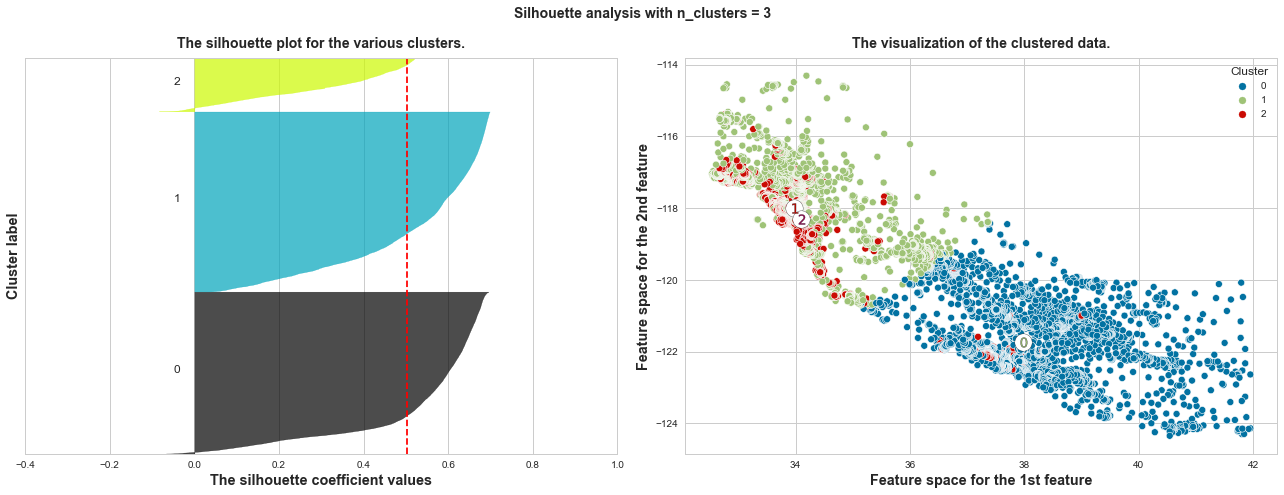

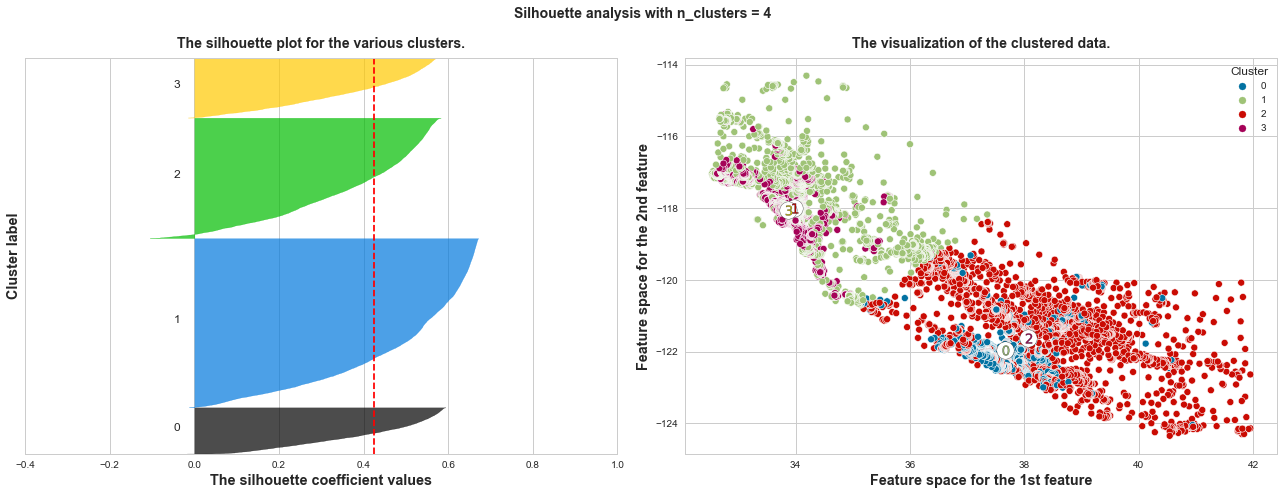

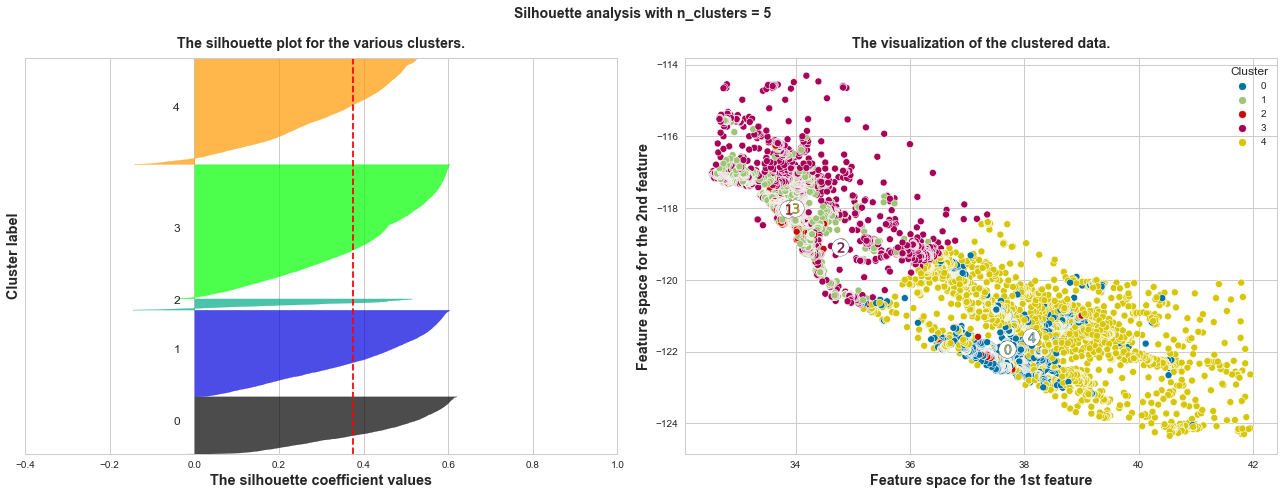

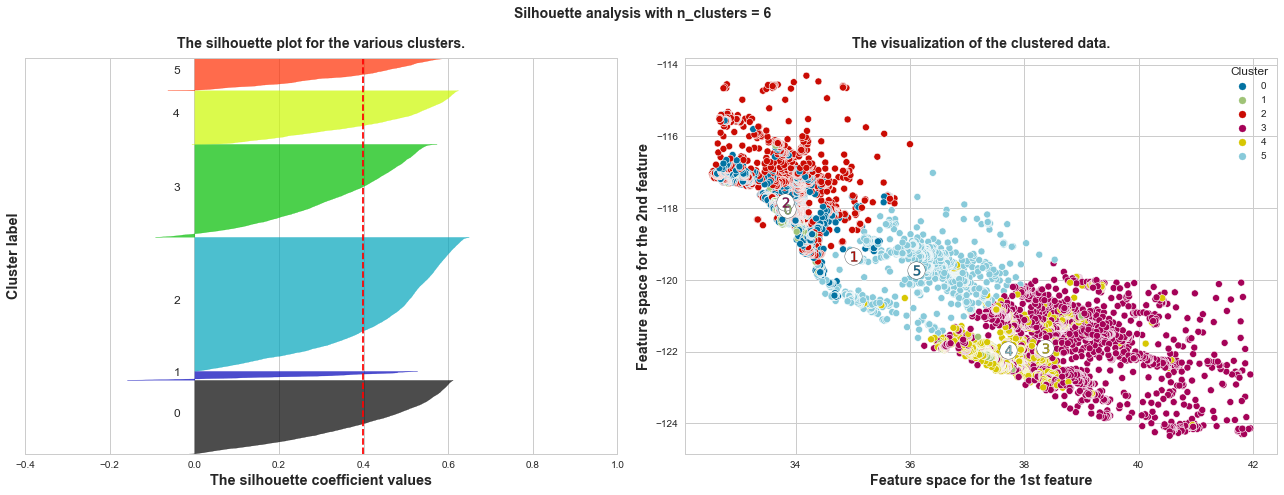

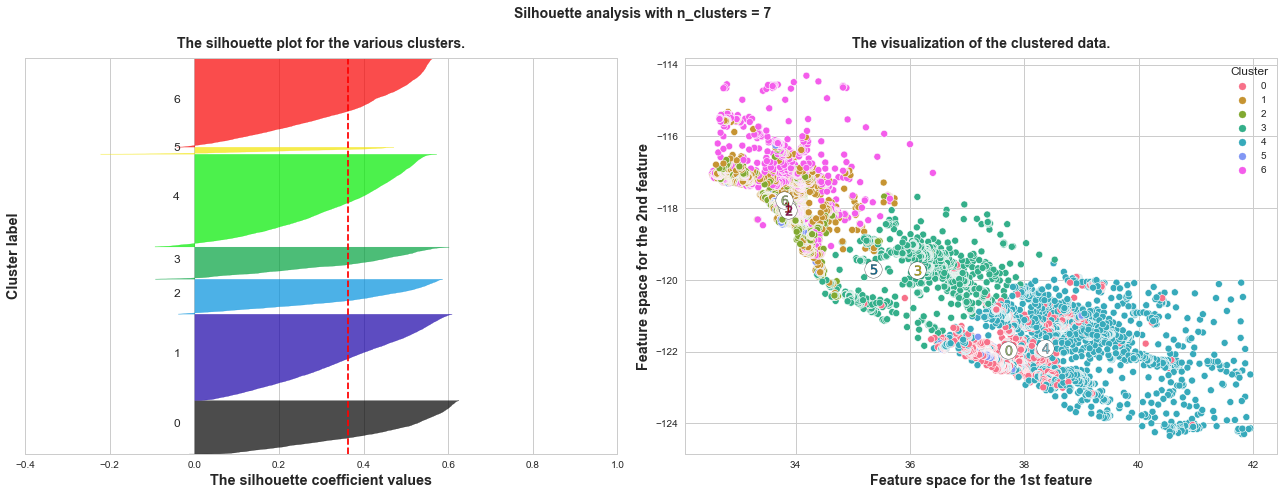

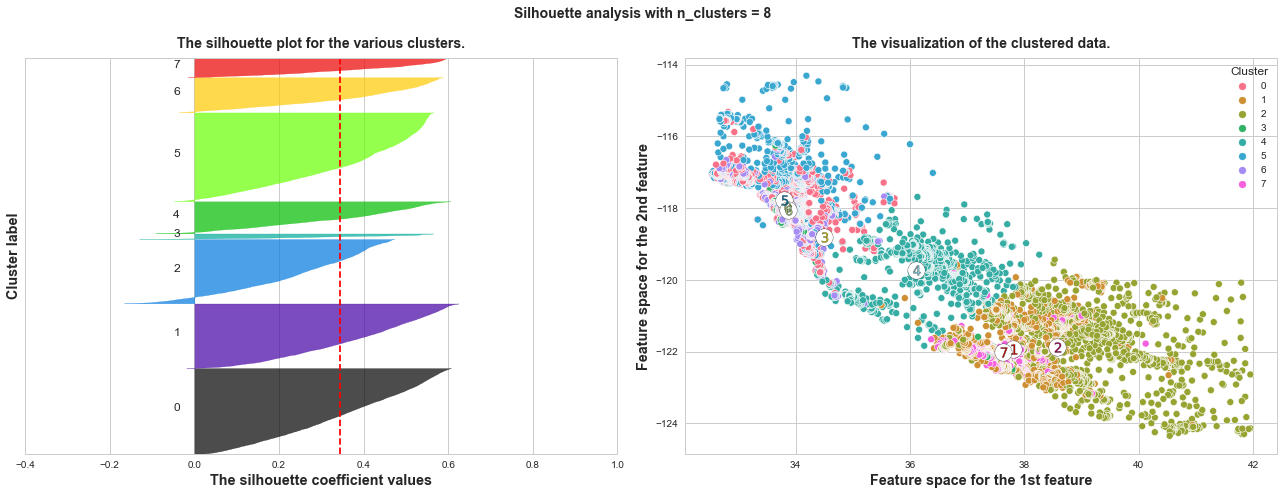

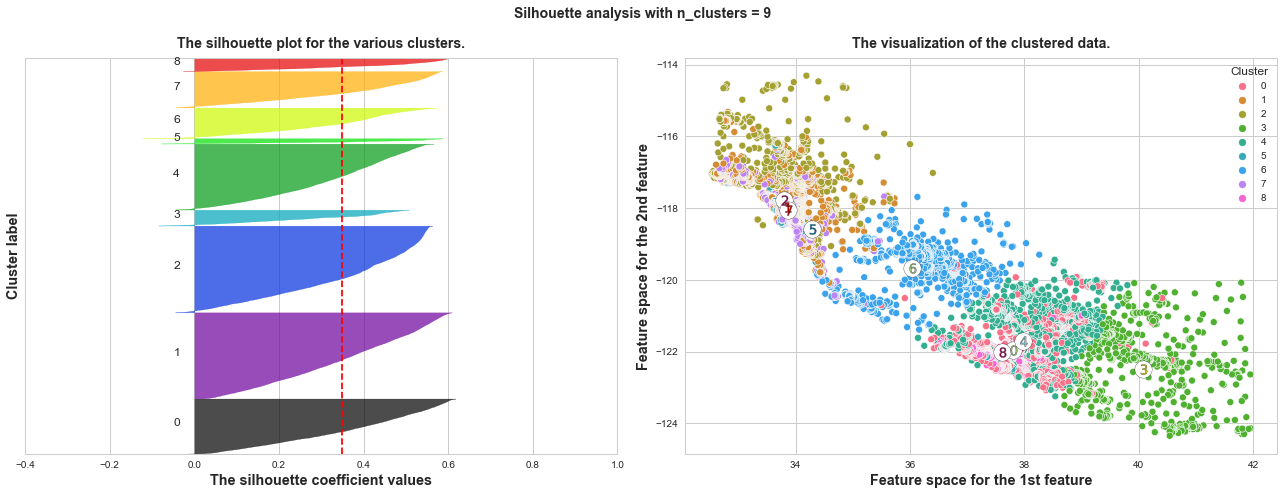

In [78]:
"""
    Return an axis with Silhouette Coefficient of all samples.
    Thicker plots means more samples on that cluster.
"""
def get_axis_silhouette_coefficient(ax, n_clusters, cluster_labels, silhouette_avg):
        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)
        
        # 1st plot showing sample scores
        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )

            # Label the silhouette plots with their cluster numbers at the middle
            ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        # Add a vertical line for average silhouette score of all the values
        ax.axvline(x=silhouette_avg, color="red", linestyle="--")
        ax.set_yticks([])
        ax.set_xticks([-0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
        ax.set_title("The silhouette plot for the various clusters.")
        ax.set_xlabel("The silhouette coefficient values")
        ax.set_ylabel("Cluster label")  
        
        return ax

"""
    Return an axis with scatter plots of clustered data, 
    marked with center of each cluster.
"""
def get_axis_clustered_data(ax, X, x_col_num, y_col_num, cluster_centers):
        # Draw a scatter plot of clustered data
        sns.scatterplot(
            x=X.columns[x_col_num], y=X.columns[y_col_num], hue="Cluster", data=X, ax=ax
        )
          
        # Draw white circles at cluster centers
        ax.scatter(
            # the center of the feature in x axis
            cluster_centers[:, x_col_num],
            # the center of the feature in y axis
            cluster_centers[:, y_col_num],
            marker="o",
            c="white",
            alpha=1,
            s=300,
            edgecolor="k",
        )
        # Draw numbers at cluster centers
        for i, c in enumerate(cluster_centers):
            ax.scatter(c[1], c[2], marker="$%d$" % i, alpha=1, s=100, edgecolor="k")

        ax.set_title("The visualization of the clustered data.")
        ax.set_xlabel("Feature space for the 1st feature")
        ax.set_ylabel("Feature space for the 2nd feature")
        
        return ax

"""
    Loop through range_n_clusters, for each # of cluster:
    - Print out the mean Silhouette Coefficient
    - Plot Silhouette Coefficient of all samples on the left axis, 
      and plot scatter plots of clustered data on the right axis.
      
    Higher the mean Silhouette Coefficient, better the performance of clusters. 
"""
def plot_silhouette_scores(X, range_n_clusters=[2], x_col_num=0, y_col_num=1):
    for n_clusters in range_n_clusters:
        # Create 2 subplots side by side
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1
        # But in this example it shouldn't lower than -0.4
        ax1.set_xlim([-0.4, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 42 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=42)
        
        # Get cluster labels and centers
        cluster_labels = clusterer.fit_predict(X)
        cluster_centers = clusterer.cluster_centers_
        
        # The silhouette_score gives the average value for all the samples.
        silhouette_avg = round(silhouette_score(X, cluster_labels), 3)
        print(f"The average silhouette_score of n_clusters={n_clusters}: {silhouette_avg}")

        # Save cluster labels so we can plot the clusters
        X_copy = X.copy()
        X_copy["Cluster"] = cluster_labels
        X_copy["Cluster"] = X_copy["Cluster"].astype("category")
        
        ax1 = get_axis_silhouette_coefficient(ax1, n_clusters, cluster_labels, silhouette_avg)    
        ax2 = get_axis_clustered_data(ax2, X_copy, x_col_num, y_col_num, cluster_centers)
        plt.suptitle(
            "Silhouette analysis with n_clusters = %d"
            % n_clusters,
            fontsize=14,
            fontweight="bold",
        )
    plt.show()

# From 2 to 9, which is the best number of clusters?
# x_col_num = 1 is the column number of `Latitude`
# y_col_num = 2 is the column number of `Longitude`
plot_silhouette_scores(X, range_n_clusters=[x for x in range(2, 10)], x_col_num=1, y_col_num=2)

What we can learn from above silhouette analysis:

- Any cluster with below average silhouette scores: when n_clusters >= 5, there are clusters with negative silhouette coefficient, we can exclude n_clusters >= 5.

- wide fluctuations: when n_clusters=3, there is wide fluctuations. Its 2nd cluster is below average score while the others are much higher than average. Thus, we can exclude n_clusters = 3.

- non-uniform thickness: when n_clusters >= 5, clusters in Silhouette plots that have non-uniform thickness, there are one or two clusters being very much thinner than others. Thus, we can exclude choice of n_clusters >= 5.

In short, n_clusters=2 is the optimal value.

#### SilhouetteVisualizer

Similarly, [Yellowbrick](https://www.scikit-yb.org/en/latest/quickstart.html) provides a visualizer model [SilhouetteVisualizer](https://www.scikit-yb.org/en/latest/api/cluster/silhouette.html) to plot Silhouette Coefficient. Let's check if the result matches with the custom function result above.

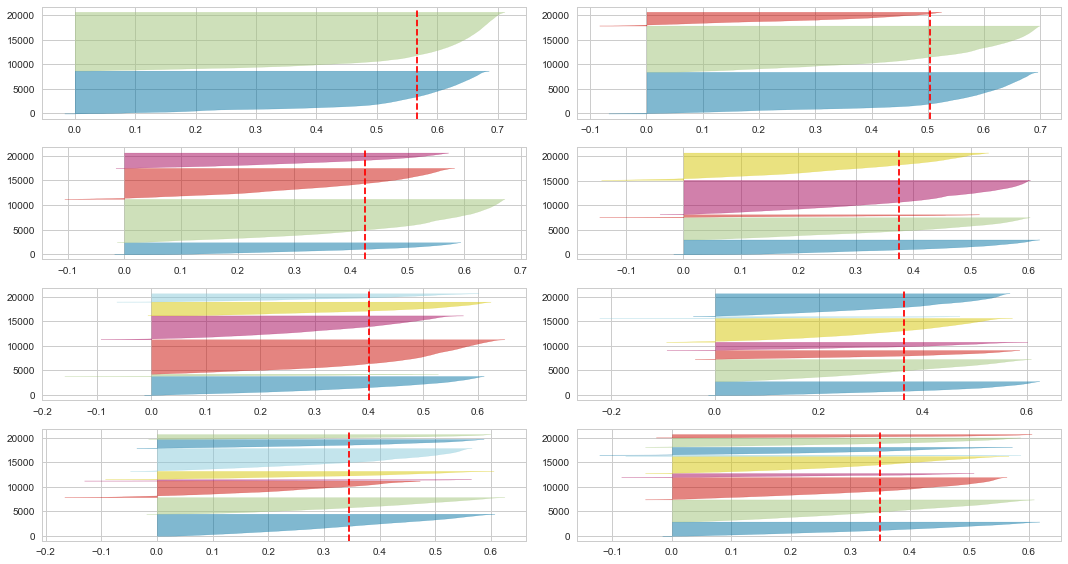

In [82]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(4, 2, figsize=(15,8))
for i in range(2, 10):
    km = KMeans(n_clusters=i, random_state=42)
    q, mod = divmod(i, 2)
    # Create SilhouetteVisualizer instance with KMeans instance
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)

The conclusion is the same, 2 is the optimal number of clusters, as its 2 clusters have similar sizes and silhouette scores, and the score is the highest.

## Elbow Method vs. Silhouette Analysis

We've known Elbow Method indicates 4 is the optimal number of clusters in K-Means, but Silouette Analysis shows it should be 2. Which should we pick, 2 or 4?

I've found many articles (for example [1](https://towardsdatascience.com/silhouette-method-better-than-elbow-method-to-find-optimal-clusters-378d62ff6891), [2](https://vitalflux.com/elbow-method-silhouette-score-which-better/)) agree that Silouette Analysis is better. Because Elbow Method simply calculates the Euclidean distance, while Silhouette Analysis is more comprehensive, considering variables such as variance, and skewness. Article [2]((https://vitalflux.com/elbow-method-silhouette-score-which-better/)) suggests using Elbow Method when the dataset has smaller size or less time complexity.

As for me, I'm not experienced enough to conclude which method is better, it needs to be analyzed on a case-by-case basis. In this example, K-Means is applied to create a new feature `Cluster`, the next step is probably to predict a target based on all features.
If possible, I'd like to use both 2 and 4 as options of `n_clusters` in GridSearch to get the best results.